# Classifying pieces of clothing

In this notebook we will classify pieces of clothing from the Fashion MNIST dataset. 

In [17]:
import os
import sys

current_path = os.getcwd()
sys.path.append(current_path + '\..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier

# Import self-made modules
from project3_code import LogisticRegression, accuracy, NeuralNetwork

First we read in the data. The downloaded data is already split in a train and test set.

In [2]:
# Read in train and test data
train_data_path = '../../../../fashion-mnist_train.csv'
test_data_path = '../../../../fashion-mnist_test.csv'

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# Have a look at data
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To scale the data we divide by 255, so that all input features have a value between 0 and 1.

In [37]:
# Split data in input and output, and scale input data
x_train = train.drop('label', axis=1).to_numpy()/255
y_train = train['label']

x_test = test.drop('label', axis=1).to_numpy()/255
y_test = test['label']

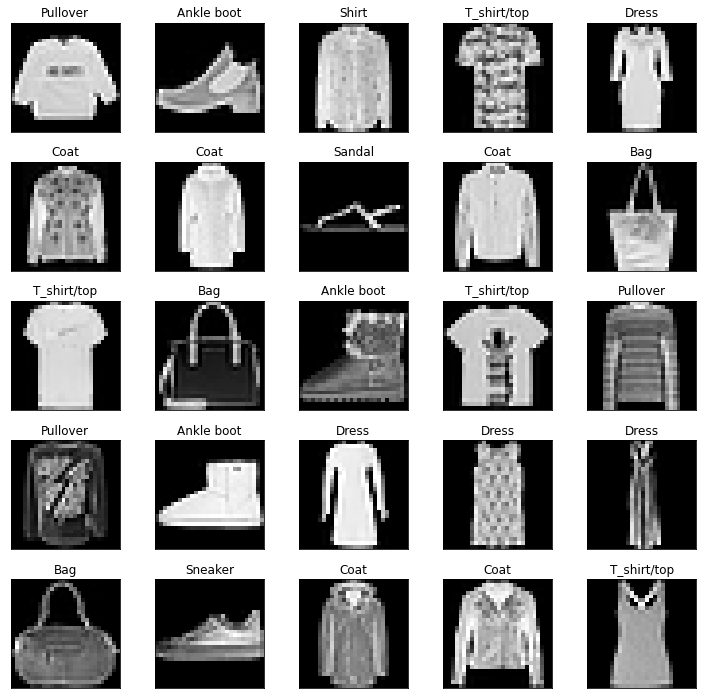

In [38]:
# Plot data
class_labels = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape((28,28)), cmap='gray')
    plt.title(class_labels[int(y_train[i])])
plt.savefig('..\\..\\output\\figures\\fashionMNIST.jpg')

### Classify data using Logistic Regression

First we classify the images using logistic regression. The code for the logistic regression class can be found in project3_code/logistic_regression.py

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/6)

In [11]:
# Find train and validation accuracies as function of number of epochs
train_acc = []
val_acc = []
for num_iterations in range(0, 210, 10):
    lr = LogisticRegression(num_classes=10, solver= 'SGD', num_batches=10, epochs=num_iterations, learning_rate=0.1, random_state=5);
    lr.fit(x_train, y_train)
    # Find train accuracy
    y_pred_train = lr.predict(x_train)
    train_accuracy = accuracy(np.array(y_pred_train), np.array(y_train))
    train_acc.append(train_accuracy)
    # Find validation accuracy
    y_pred_val = lr.predict(x_val)
    val_accuracy = accuracy(np.array(y_pred_val), np.array(y_val))
    val_acc.append(val_accuracy)
    

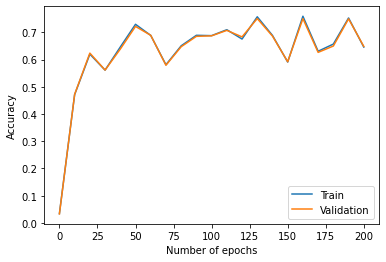

In [15]:
plt.plot(range(0, 210, 10), train_acc, label = 'Train');
plt.plot(range(0, 210, 10), val_acc, label='Validation');
plt.legend();
plt.xlabel('Number of epochs');
plt.ylabel('Accuracy');
plt.savefig('..\\..\\output\\figures\\logreg_epochs.jpg')

In [20]:
# Time the code for different number of mini batches
train_acc = []
times = []
for batches in [1, 2, 10, 24]:
    time_start = time.process_time()
    lr = LogisticRegression(num_classes=10, solver= 'SGD', num_batches=batches, epochs=50, learning_rate=0.1, random_state=5);
    lr.fit(x_train, y_train)
    time_end = time.process_time()
    times.append(time_end - time_start)
    y_pred_train = lr.predict(x_train)
    train_accuracy = accuracy(np.array(y_pred_train), np.array(y_train))
    train_acc.append(train_accuracy)   

In [21]:
times

[227.453125, 115.578125, 27.9375, 14.625]

In [22]:
train_acc

[0.59054, 0.58826, 0.72986, 0.67996]

In [28]:
# Find test error
lr_final = LogisticRegression(num_classes=10, solver= 'SGD', num_batches=10, epochs=100, learning_rate=0.1, random_state=5)
lr_final.fit(x_train, y_train)

y_pred_test = lr.predict(x_test)
test_acc = accuracy(np.array(y_pred_test), np.array(y_test))
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.674


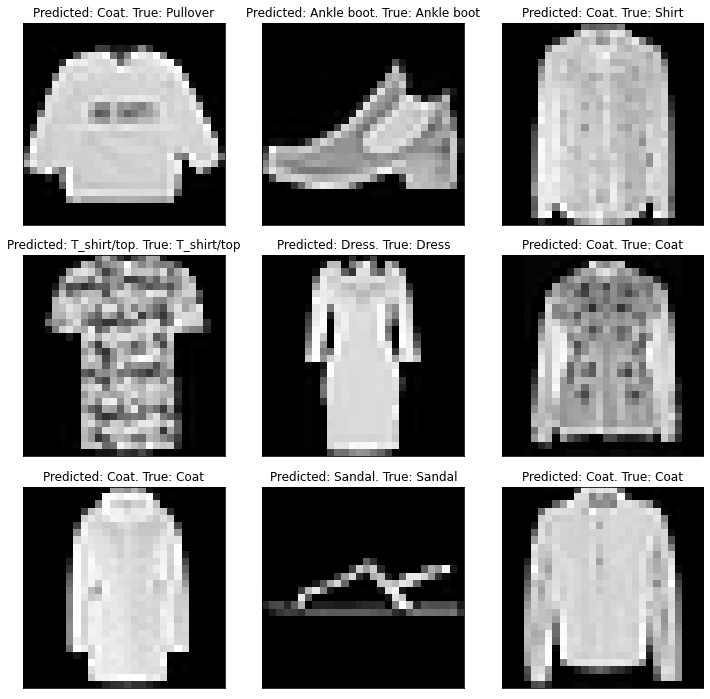

In [40]:
# Plot data
class_labels = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

y_pred = lr.predict(x_train)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape((28,28)), cmap='gray')
    plt.title(f'Predicted: {class_labels[int(y_pred[i])]}. True: {class_labels[int(np.array(y_train)[i])]}')
plt.savefig('..\\..\\output\\figures\\pred_logreg.jpg')

## Classifying using a neural network
Our next method is the neural network. We wil use the MPLclassifier from sklearn.

As sklearn split in train and validation intrinsically, we redefine the train set to include the whole data set.

In [24]:
x_train = train.drop('label', axis=1).to_numpy()/255
y_train = train['label']

In [23]:
# use neural network with 2 hidden layers with 100 nodes in each layer
time_start = time.process_time()
clf =  MLPClassifier(alpha=0.05,solver='sgd', random_state=1,
                hidden_layer_sizes=[100, 100], verbose=10, max_iter=30, early_stopping=True)

clf.fit(x_train, y_train)
time_end = time.process_time()
print(time_end - time_start)

print("Score train = ",clf.score(x_train, y_train))
print("Score test  = ",clf.score(x_test, y_test))

Iteration 1, loss = 1.71792141
Validation score: 0.662600
Iteration 2, loss = 0.95641292
Validation score: 0.721400
Iteration 3, loss = 0.78517778
Validation score: 0.759400
Iteration 4, loss = 0.70788093
Validation score: 0.779600
Iteration 5, loss = 0.65633859
Validation score: 0.793200
Iteration 6, loss = 0.62017512
Validation score: 0.804800
Iteration 7, loss = 0.59259607
Validation score: 0.809400
Iteration 8, loss = 0.57187402
Validation score: 0.815600
Iteration 9, loss = 0.55529440
Validation score: 0.821400
Iteration 10, loss = 0.54195035
Validation score: 0.825200
Iteration 11, loss = 0.53110276
Validation score: 0.825800
Iteration 12, loss = 0.52170875
Validation score: 0.830600
Iteration 13, loss = 0.51350913
Validation score: 0.830200
Iteration 14, loss = 0.50634824
Validation score: 0.834200
Iteration 15, loss = 0.50014841
Validation score: 0.835200
Iteration 16, loss = 0.49468244
Validation score: 0.835800
Iteration 17, loss = 0.48979348
Validation score: 0.839000
Iterat

C:\Users\odala\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


Score train =  0.85972
Score test  =  0.8534


In [ ]:
plt.plot(clf.loss_curve_);
plt.plot(clf.validation_scores_);